# GAMALOS (GAlaxies MAking LOve Simulation)

# Theoric remarks

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

# Computation

## Import the packages and the data

In [1]:
import numpy as np
import pandas as pd
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_leapfrog_galaxy, integrator_leapfrog, integrator_leapfrog_galaxy_encounter, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

<div class='alert alert-block alert-warning'>
occhio che ho preso 1e4 particelle!!
</div>

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# slice dataframe
num_trackers = 1e3
df = df_0.iloc[:int(num_trackers)]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


## Initial conditions
We generated a Particles instance for each galaxy to differentiate them. 

In [3]:
# create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array as 1D array
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)

# do the same for the other galaxy
# this second galaxy is the same as the first one, but translated by a certain value

pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

# apply this translation to find the second galaxy

positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)


## Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius. 

---

## Helper functions
Let's define some helper functions: 
* `rotation_curve_rescaled`: takes as input the class and the particle we defined as the galactic center and outputs the cylindrical radius and the azimuthal velocity (rescaled to the galactic center);
* `surface_density`: computes the numerical surface density taking as input the cylindrical radius;
* `ìntegration_leapfrog`: integrates the galaxy over the time of the simulation using the integrator leapfrog, moreover computes the cyclindrical radius and the azimuthal velocity using `rotation_curve_rescaled`.

In [4]:
from helper_functions_gamalos import *

----

## Galaxy 1
Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method).

In [5]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

radius = np.sqrt(np.sum((Galaxy1.pos-Galaxy1.pos[0])**2., axis=1))  # radius array

central_mass = Galaxy1.mass[0]                                           # central mass of the galaxy

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))        # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_time, Galaxy1_Rcyl, Galaxy1_Vphi, Galaxy1_Vr, Galaxy1_Vz = integration_leapfrog(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght, GC=0)

print(Galaxy1_orbit.shape)
# (iterations, particles, coordinates)

Period of the galaxy (approximately): 104.8239304318399
(1000, 1000, 3)


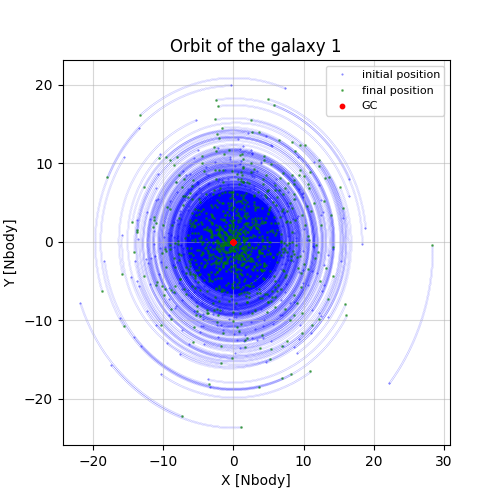

In [6]:
plot_orbit_single_galaxy(Galaxy1_orbit, 'Orbit of the galaxy 1')

### Stability of the rotation curve and of the surface density

We check that both the rotation curve and the surface density of the galaxy after running one simulation remain stable after a timescale defined as the mean period of the galaxy

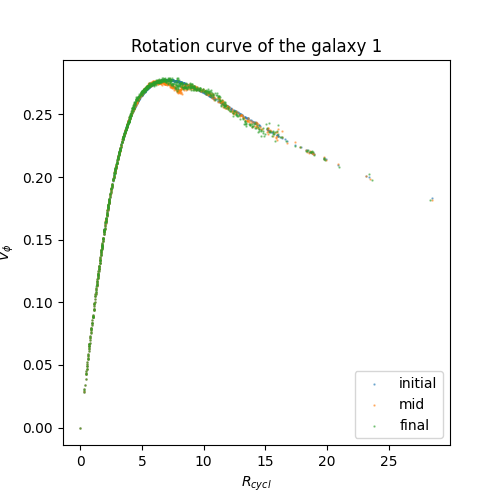

In [7]:
rotcurve_plot(Galaxy1_Rcyl, Galaxy1_Vphi, 'Rotation curve of the galaxy 1')

In [8]:
# intial surface density
mid, H, area = surface_density(Galaxy1_Rcyl[0])

# final surface density
mid_end, H_end, area_end = surface_density(Galaxy1_Rcyl[-1])

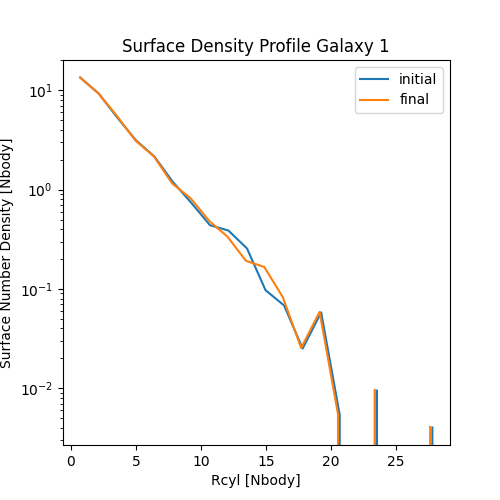

In [9]:
plot_surface_density(mid, H, area, mid_end, H_end, area_end, 'Surface Density Profile Galaxy 1')

## Galaxy 2

### Stability of the rotation curve and of the surface density
We do the same check for the other galaxy, so first we run a simulation and then we check the stability of the rotation curve and of the surface density. 

In [10]:
# compute the orbital period with T = 2*pi*sqrt(a^3/GM)

G = 1.                                                                   # gravitational constant in n-body units
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)

central_mass2 = Galaxy1.mass[0]                                           # central mass of the galaxy
radius = np.sqrt(np.sum((Galaxy2.pos-Galaxy2.pos[0])**2., axis=1))  # radius array

T = 2 * np.pi * np.sqrt(radius**3 / (G * central_mass))        # period of the galaxy using radius array  
T = np.mean(T)                                                           # mean period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# define the time of simulation and the number of steps

t0 = 0.                         # initial time
tsimulation = 1*T               # time of simulation (one period)
N = int(1e3)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Galaxy2_test = Galaxy2.copy()

Galaxy2_orbit, Galaxy2_stars_vel, Galaxy2_time, Galaxy2_Rcyl, Galaxy2_Vphi, Galaxy2_Vr, Galaxy2_Vz = integration_leapfrog(galaxy=Galaxy2_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght, GC=0)


Period of the galaxy (approximately): 104.8239304318399


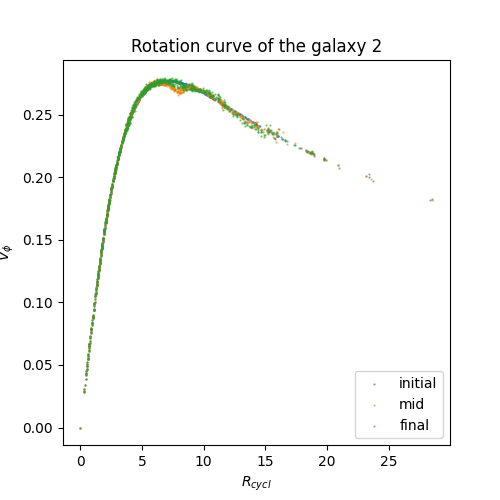

In [11]:
rotcurve_plot(Galaxy2_Rcyl, Galaxy2_Vphi, 'Rotation curve of the galaxy 2')

In [12]:
# intial surface density
mid, H, area = surface_density(Galaxy2_Rcyl[0])

# final surface density
mid_end, H_end, area_end = surface_density(Galaxy2_Rcyl[-1])

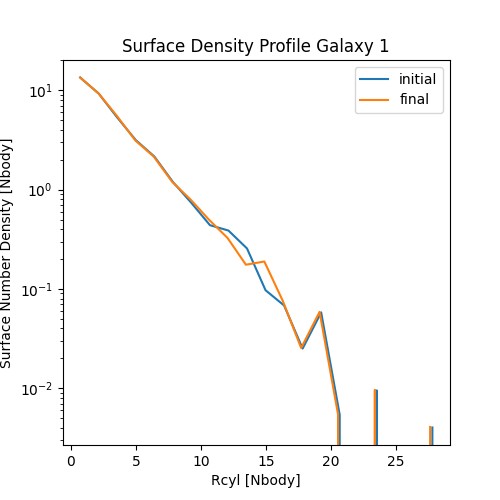

In [13]:
plot_surface_density(mid, H, area, mid_end, H_end, area_end, 'Surface Density Profile Galaxy 2')

----    

## Galaxy encounter

We run a galaxy encounter and then show how the rotation curve and the disc surface profile evolve with time. 
First of all, we make a single class with both galaxies. 

In [14]:
# Combine Galaxy1 and Galaxy2 into a single Particles class
combined_pos = np.concatenate((Galaxy1.pos, Galaxy2.pos))
combined_vel = np.concatenate((Galaxy1.vel, Galaxy2.vel))
combined_mass = np.concatenate((Galaxy1.mass, Galaxy2.mass))

Combined_Galaxies = Particles(combined_pos, combined_vel, combined_mass)

div = int(num_trackers) # first index of the second galaxy

We have defined another function for the integration `integration_leapfrog_encounter` to differentiate the rescaling for the two galaxies based on the ID of the particles. 

Then we run the simulation for the encounter using $T=210$ as time of the simulation.

In [15]:
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_test = Combined_Galaxies.copy()

Combined_Galaxies_orbit, Combined_Galaxies_stars_vel, Combined_Galaxies_time, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, Combined_Galaxies_Vr, Combined_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Combined_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

### Plot of the whole evolution
We make a plot showing the whole evolution of the galaxies, namely the trajectories of the trackers and of the galactic centers. We display even the initial and final positions of the galaxies. 

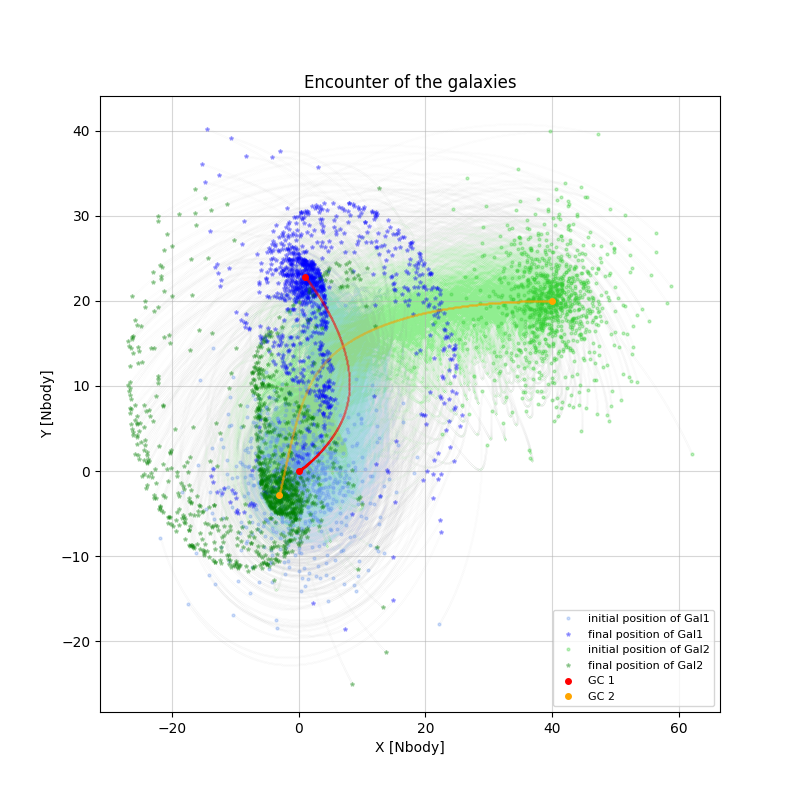

In [16]:
plot_encounter(Combined_Galaxies_orbit, 'Encounter of the galaxies', div)

### Final situation
We make a plot showing the final configuration of the galaxies after the encounter, the evolution of the rotation curve and the evolution of the surface density profile.  

In [17]:
# intial surface density G1
mid_in_1, H_in_1, area_in_1 = surface_density(Combined_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_end_1, H_end_1, area_end_1 = surface_density(Combined_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_in_2, H_in_2, area_in_2 = surface_density(Combined_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_end_2, H_end_2, area_end_2 = surface_density(Combined_Galaxies_Rcyl[-1,div:])

## Final plots after the encounter
Let's make a single plot containing the final situation of the galaxies, the evolution of their rotation curve and the one of their surface density. 

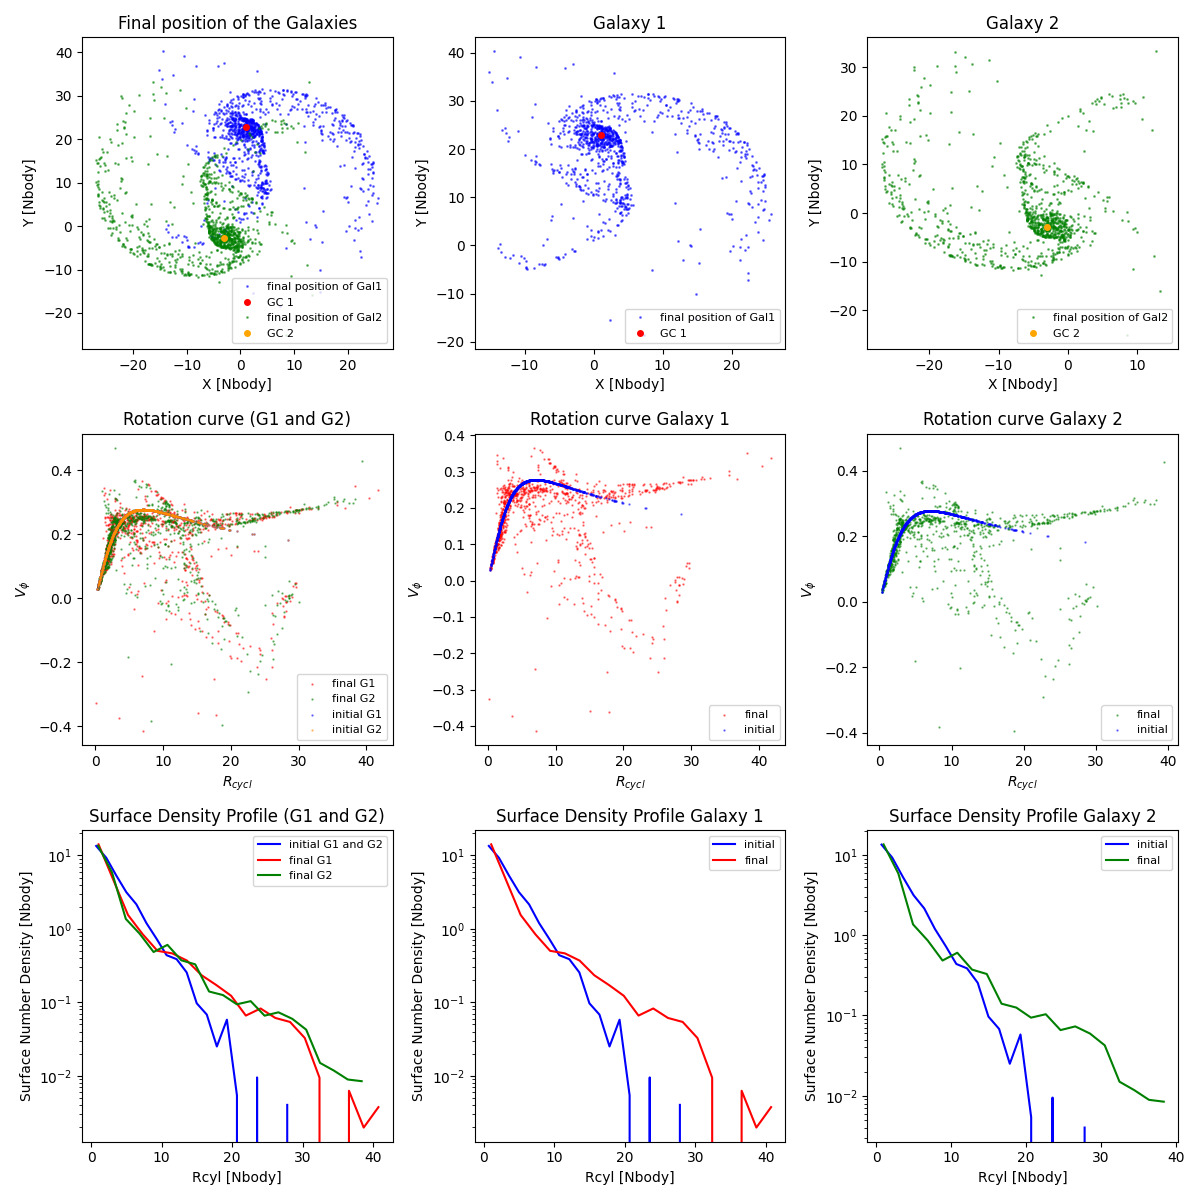

In [18]:
subplot_positions_rotcurve_density(Combined_Galaxies_orbit, Combined_Galaxies_Rcyl, Combined_Galaxies_Vphi, 
                                       mid_in_1, H_in_1, area_in_1, mid_end_1, H_end_1, area_end_1, 
                                       mid_in_2, H_in_2, area_in_2, mid_end_2, H_end_2, area_end_2,
                                       div)

### Evolution of radial and vertical velocity

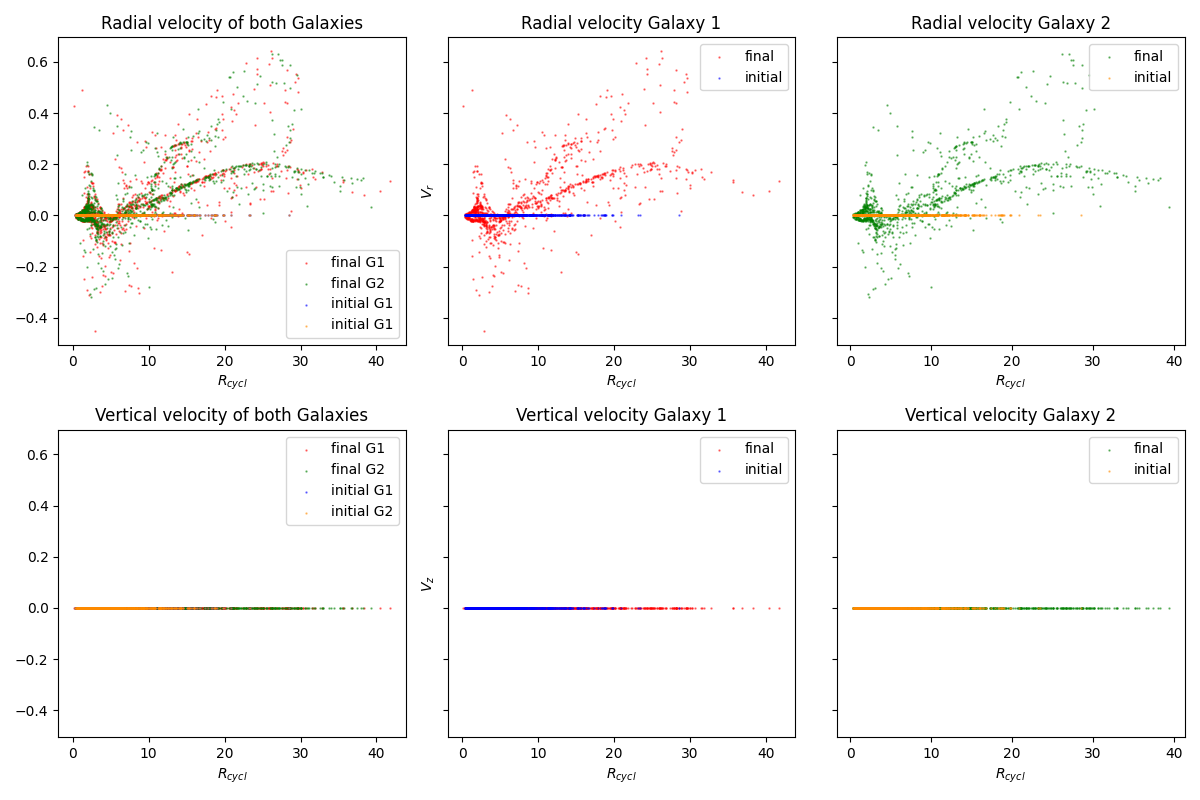

In [19]:
subplots_radial_vertical_vel(Combined_Galaxies_Rcyl, Combined_Galaxies_Vr, Combined_Galaxies_Vz, div)

While the radial velocity changes, the vertical velocity remains zero meaning that the trackers are moving only in a plane. 

## Counter-rotating galaxies

In [20]:
# invert the velocity of the second galaxy
Combined_Galaxies_counter = Combined_Galaxies.copy()
Combined_Galaxies_counter.vel[1:div] = -Combined_Galaxies_counter.vel[1:div]


In [21]:
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
T_sim = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
tsimulation = T_sim
N = int(1e3)
h = (tsimulation - t0)/N

Counter_Galaxies_test = Combined_Galaxies_counter.copy()

Counter_Galaxies_orbit, Counter_Galaxies_stars_vel, Counter_Galaxies_time, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi, Counter_Galaxies_Vr, Counter_Galaxies_Vz = integration_leapfrog_encounter(galaxy=Counter_Galaxies_test, h=h, 
                                                                                                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

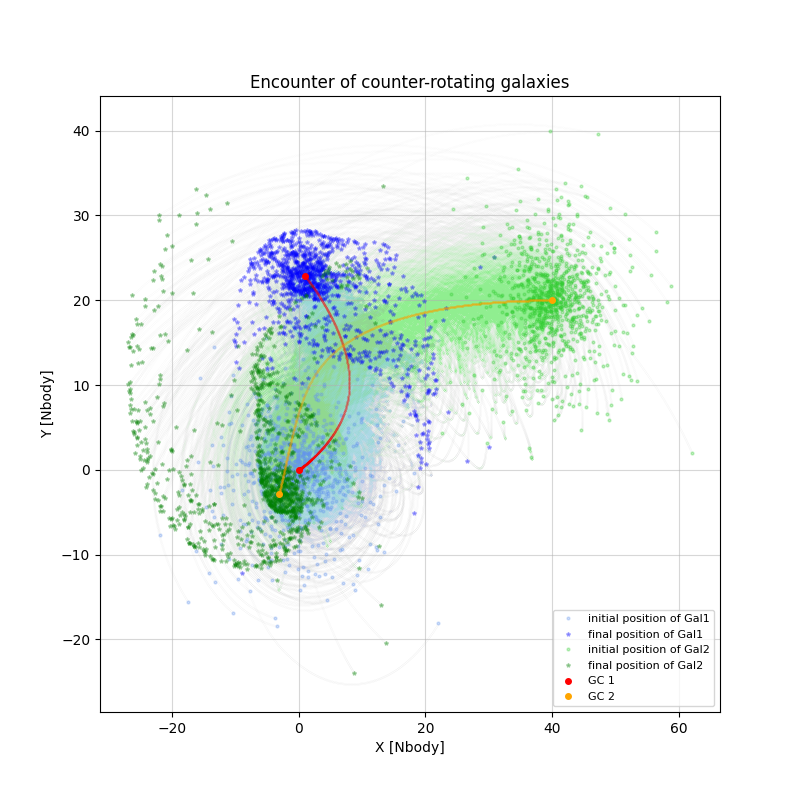

In [22]:
plot_encounter(Counter_Galaxies_orbit, 'Encounter of counter-rotating galaxies', div)

In [23]:
# intial surface density G1
mid_c_in_1, H_c_in_1, area_c_in_1 = surface_density(Counter_Galaxies_Rcyl[0,:div])

# final surface density G1
mid_c_end_1, H_c_end_1, area_c_end_1 = surface_density(Counter_Galaxies_Rcyl[-1,:div])

# intial surface density G2 
mid_c_in_2, H_c_in_2, area_c_in_2 = surface_density(Counter_Galaxies_Rcyl[0,div:])

# final surface density G2
mid_c_end_2, H_c_end_2, area_c_end_2 = surface_density(Counter_Galaxies_Rcyl[-1,div:])

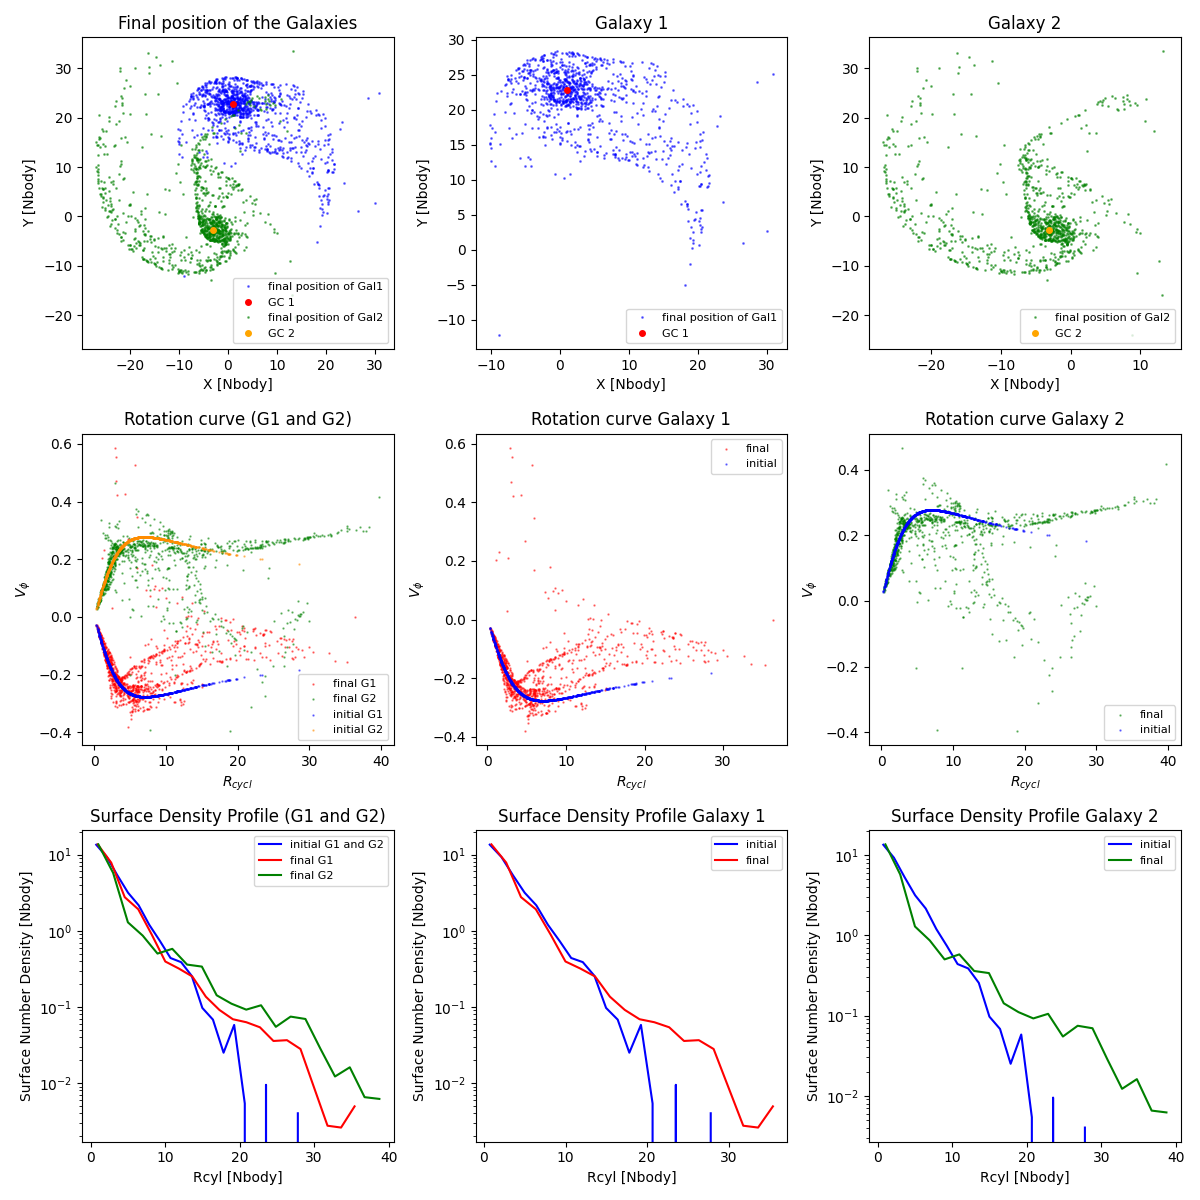

In [24]:
subplot_positions_rotcurve_density(Counter_Galaxies_orbit, Counter_Galaxies_Rcyl, Counter_Galaxies_Vphi,
                                    mid_c_in_1, H_c_in_1, area_c_in_1, mid_c_end_1, H_c_end_1, area_c_end_1, 
                                    mid_c_in_2, H_c_in_2, area_c_in_2, mid_c_end_2, H_c_end_2, area_c_end_2,
                                    div)

## Inclined galaxies

Let us call $(x,y,z)$ the starting reference frame, and $(x',y',z')$ the one in which we want to put ourselves. The second one is obtained through a rotation of the x-axis by an arbitrary angle $\alpha$ . In order to have consistency with astrophysical cases we will use the angle $i$ which is simply the complementary angle of $\alpha$: in particular $i = 90 \degree - \alpha$. Then, we have 
$$
\begin{cases}
    x' = x cos (\alpha) = x sin (i) \\
    y' = y \\
    z' = x sin (\alpha) = x cos (i) 

\end{cases}
$$
Putting this in matricial form
$$
\begin{pmatrix}

     \cos(\alpha) & 0 & -\sin(\alpha) \\
    1 & 0 & 0 \\
     \sin(\alpha) &0 & \cos(\alpha)
\end{pmatrix}
$$
So that, being R this matrix, $\vec{r}' = R \cdot \vec{r}$. \
We can now re-define our dataframe so to account for this rotation.

In [25]:
# first, we define a function for the rotation by an angle alpha around the y axis

def rotation_y(alpha: float, x: float, y: float, z: float) -> Tuple[float, float, float]:
    """
    Rotate the point (x, y, z) by an angle alpha around the y axis
    """
    R = np.array([[np.cos(alpha), 0, np.sin(alpha)], [0, 1, 0], [-np.sin(alpha), 0, np.cos(alpha)]])
    point = np.array([x, y, z])
    new_point = np.dot(R, point)

    """
    Same as
    x_new = x * np.cos(alpha) + z * np.sin(alpha)
    y_new = y
    z_new = -x * np.sin(alpha) + z * np.cos(alpha)
    """

    return new_point[0], new_point[1], new_point[2]




In [26]:
Galaxy1_inclined = Galaxy1.copy()
Galaxy2_inclined = Galaxy2.copy()

# rotate the first galaxy by an angle of 45 degrees around the y axis
alpha = np.pi/4
for i in range(len(Galaxy1_inclined.pos)):
    Galaxy1_inclined.pos[i] = rotation_y(alpha, Galaxy1_inclined.pos[i][0], Galaxy1_inclined.pos[i][1], Galaxy1_inclined.pos[i][2])
    Galaxy1_inclined.vel[i] = rotation_y(alpha, Galaxy1_inclined.vel[i][0], Galaxy1_inclined.vel[i][1], Galaxy1_inclined.vel[i][2])


#Inclined_Galaxies = Combined_Galaxies.copy()

In [27]:
Galaxy1_inclined_test = Galaxy1_inclined.copy()
Galaxy2_inclined_test = Galaxy2_inclined.copy()

# Combine Galaxy1_inclined and Galaxy2_inclined into a single Particles class

num = int(len(Galaxy1_inclined.mass))

combined_pos = np.concatenate((Galaxy1_inclined.pos, Galaxy2_inclined.pos))
combined_vel = np.concatenate((Galaxy1_inclined.vel, Galaxy2_inclined.vel))
combined_mass = np.concatenate((Galaxy1_inclined.mass, Galaxy2_inclined.mass))

Combined_Galaxies_inclined = Particles(combined_pos, combined_vel, combined_mass)

#evolve the combined galaxy with the leapfrog integrator

# reinitialize all the variables
# just keep the same tsimulation and N as before
G = 1.                                                                   # gravitational constant in n-body units
tsimulation = 210
plummer_scale_lenght = 5.                                                # scale lenght of the plummer sphere (softening)
t0 = 0.
N = int(1e3)
h = (tsimulation - t0)/N

Combined_Galaxies_inclined_test = Combined_Galaxies_inclined.copy()

Combined_Galaxies_inclined_orbit, Combined_Galaxies_inclined_stars_vel, Combined_Galaxies_inclined_time, Combined_Galaxies_inclined_Rcyl, Combined_Galaxies_inclined_Vphi, Combined_Galaxies_inclined_Vr, Combined_Galaxies_inclined_Vz = integration_leapfrog_encounter(galaxy=Combined_Galaxies_inclined_test, h=h,
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)



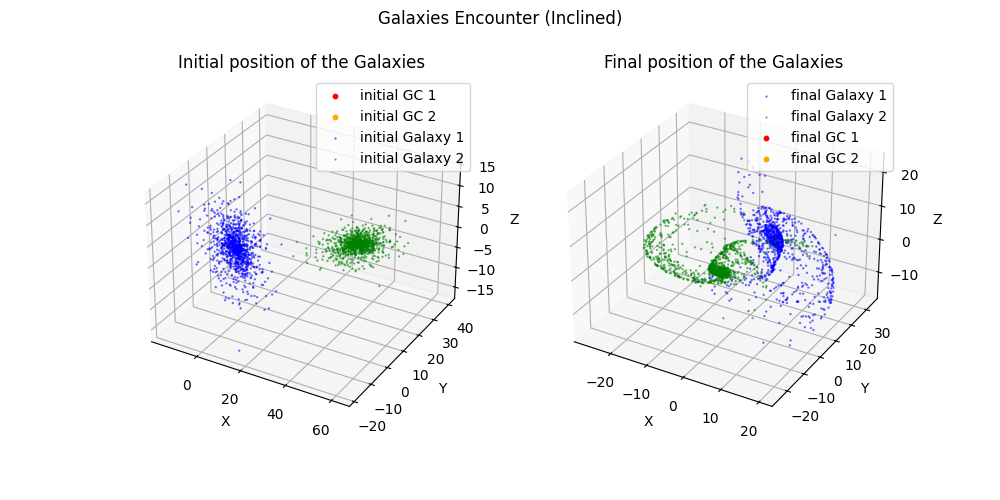

In [28]:
plot_3d_initial_final(Combined_Galaxies_inclined_orbit, div, num, 'Galaxies Encounter (Inclined)')

In [29]:
#plot_orbit_3d(Combined_Galaxies_inclined_orbit, div)